In [124]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import ViT_B_16_Weights
from torchvision.models.vision_transformer import vit_b_16
import torch.backends.mps
import math

import data
import eval
import vit
import train
import utils

In [125]:
import importlib


def reload():
    importlib.reload(data)
    importlib.reload(eval)
    importlib.reload(vit)
    importlib.reload(train)
    importlib.reload(utils)


reload()

In [126]:
import utils

device = utils.get_device()

# ------------------Model architecture hyperparameters--------------------
L = 12
D = 768
HEADS = 12
PATCH = 16
IMAGE_W = 224
assert IMAGE_W % PATCH == 0, "Image size must be divisible by the patch size"
N = int((IMAGE_W / PATCH) ** 2)
assert D % HEADS == 0, "The latent vector size D must be divisible by the number of heads"
# To keep num of params constant we set DH = D/HEADS
DH = int(D / HEADS)
DMSA = HEADS * DH * 3
DMLP = 3072
NORM_EPS = 1e-6

# ---------------------Fine-tuning hyperparameters------------------------
LR = 0.003
MOMENTUM = 0.9
STEPS = 10000
BATCH = 32
DROPOUT = 0.0

# ----------------------------Other consts--------------------------------
SEED = 100
EVALS_PER_EPOCH = 1
IMAGENET_CLASSES_N = 1000

Using device: mps


In [127]:
device = utils.get_device()

Using device: mps


In [128]:
print("Loading CIFAR-10 dataset")
train_ds, train_dl = data.load_CIFAR(
    train=True, batch_size=BATCH, transforms=ViT_B_16_Weights.DEFAULT.transforms(), seed=SEED
)
test_ds, test_dl = data.load_CIFAR(
    train=False, batch_size=BATCH, transforms=ViT_B_16_Weights.DEFAULT.transforms(), seed=SEED
)

Loading CIFAR-10 dataset
Files already downloaded and verified
Created 1563 train batches of size 32
Files already downloaded and verified
Created 313 test batches of size 32


In [129]:
epochs = math.ceil(STEPS * BATCH / len(train_ds))
epochs

7

In [123]:
classes = test_ds.classes

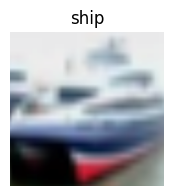

In [103]:
utils.show(test_ds, 1)

# Going wild with fine-tuning

In [104]:
print("Creating the reference model")
weights = ViT_B_16_Weights.DEFAULT
torch.manual_seed(SEED)
ref_model = vit_b_16(weights=weights, dropout=DROPOUT).to(device)

Creating the reference model


In [105]:
print("Freezing the model and swapping it's classification head")
# freeze the ref model
for p in ref_model.parameters():
    p.requires_grad = False

# swap the classification layer
torch.manual_seed(SEED)
lin = nn.Linear(in_features=D, out_features=len(classes))
lin.weight = nn.Parameter(torch.zeros(len(classes), D))
lin.bias = nn.Parameter(torch.zeros(len(classes)))
ref_model.heads = nn.Sequential(lin).to(device)
# summary(ref_model, depth=4, input_size=(1, 3, IMAGE_W, IMAGE_W),col_names=["kernel_size", "input_size", "output_size", "num_params","trainable"], row_settings=["var_names"],)

Freezing the model and swapping it's classification head


In [106]:
optim = torch.optim.SGD(ref_model.parameters(), lr=LR, momentum=MOMENTUM)

In [115]:
print("Fine-tuning the reference model")
torch.manual_seed(SEED)
train_metrics, test_metrics = train.train(
    ref_model,
    epochs,
    train_dl,
    test_dl,
    device,
    len(classes),
    optim,
    nn.CrossEntropyLoss(),
    EVALS_PER_EPOCH,
    checkpoints=epochs,
)

Fine-tuning the reference model


Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch 4:
Train: Accuracy = 0.781, Loss = 0.037, Precision = 0.841, Recall = 0.724
Testing:


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Test: Accuracy = 0.672, Loss = 0.044, Precision = 0.722, Recall = 0.650

Model is saved to /Users/yehormanevych/Projects/ViT/models/2023-09-06_00.50.34_VisionTransformer_67%_e0.pth


Epoch 1


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch 4:
Train: Accuracy = 0.706, Loss = 0.036, Precision = 0.794, Recall = 0.672
Testing:


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Test: Accuracy = 0.750, Loss = 0.038, Precision = 0.850, Recall = 0.727

Model is saved to /Users/yehormanevych/Projects/ViT/models/2023-09-06_00.50.43_VisionTransformer_75%_e1.pth


Epoch 2


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch 4:
Train: Accuracy = 0.788, Loss = 0.031, Precision = 0.845, Recall = 0.756
Testing:


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Test: Accuracy = 0.781, Loss = 0.034, Precision = 0.860, Recall = 0.755

Model is saved to /Users/yehormanevych/Projects/ViT/models/2023-09-06_00.50.51_VisionTransformer_78%_e2.pth


Epoch 3


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch 4:
Train: Accuracy = 0.788, Loss = 0.027, Precision = 0.837, Recall = 0.751
Testing:


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Test: Accuracy = 0.797, Loss = 0.030, Precision = 0.865, Recall = 0.769



KeyboardInterrupt: 

In [ ]:
eval.plot_metrics(train_metrics, test_metrics)

In [ ]:
eval.eval_show(ref_model, test_ds, n=16, page=0)

In [ ]:
accuracy = test_metrics[eval.Metrics.ACCURACY.value][-1].item()
utils.save_model(ref_model, accuracy, "FT_CIFAR")